In [186]:
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import re
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MultiLabelBinarizer
import nlp_preproc_functions as preproc
import ast

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

os.chdir('/Users/jon/Documents/DSDM/term_2/adv_meth_nlp/nlp-final/')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to /Users/jon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data exploration

First load the datasets

In [187]:
#english
en_train = load_dataset('multi_eurlex', 'en', split='train')
en_test = load_dataset('multi_eurlex', 'en', split='test')
en_val = load_dataset('multi_eurlex', 'en', split='validation')

#french
fr_train = load_dataset('multi_eurlex', 'fr', split='train')
fr_test = load_dataset('multi_eurlex', 'fr', split='test')
fr_val = load_dataset('multi_eurlex', 'fr', split='validation')

#spanish
es_train = load_dataset('multi_eurlex', 'es', split='train')
es_test = load_dataset('multi_eurlex', 'es', split='test')
es_val = load_dataset('multi_eurlex', 'es', split='validation')

Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/multi_eurlex/en/1.0.0/e50b15921a24b8e33941240fe19542e492392357f145d933bd497812181d610d)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/multi_eurlex/en/1.0.0/e50b15921a24b8e33941240fe19542e492392357f145d933bd497812181d610d)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/multi_eurlex/en/1.0.0/e50b15921a24b8e33941240fe19542e492392357f145d933bd497812181d610d)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/multi_eurlex/fr/1.0.0/e50b15921a24b8e33941240fe19542e492392357f145d933bd497812181d610d)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/multi_eurlex/fr/1.0.0/e50b15921a24b8e33941240fe19542e492392357f145d933bd497812181d610d)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/multi_eurlex/fr/1.0.0/e50b15921a24b8e33941240fe19542e492392357f145d933bd497812181d610d)
Found cached dataset multi_e

`eurovoc_id` is the ID of a certain area of government activity.

`level` refers to the specificity of a certain topic. For example, european parliament is level 0, quantum computing is level 7.

In [146]:
# Load (label_id, descriptor) mapping 
with open('./data/eurovoc_descriptors.json') as jsonl_file:
    eurovoc_descriptors =  json.load(jsonl_file)

# Load (label_id, descriptor) mapping 
with open('./data/eurovoc_concepts.json') as jsonl_file:
    eurovoc_concepts =  json.load(jsonl_file)


Let's take a look at the class imbalance for our predictor variables. Please note that we're currently only looking at English. 

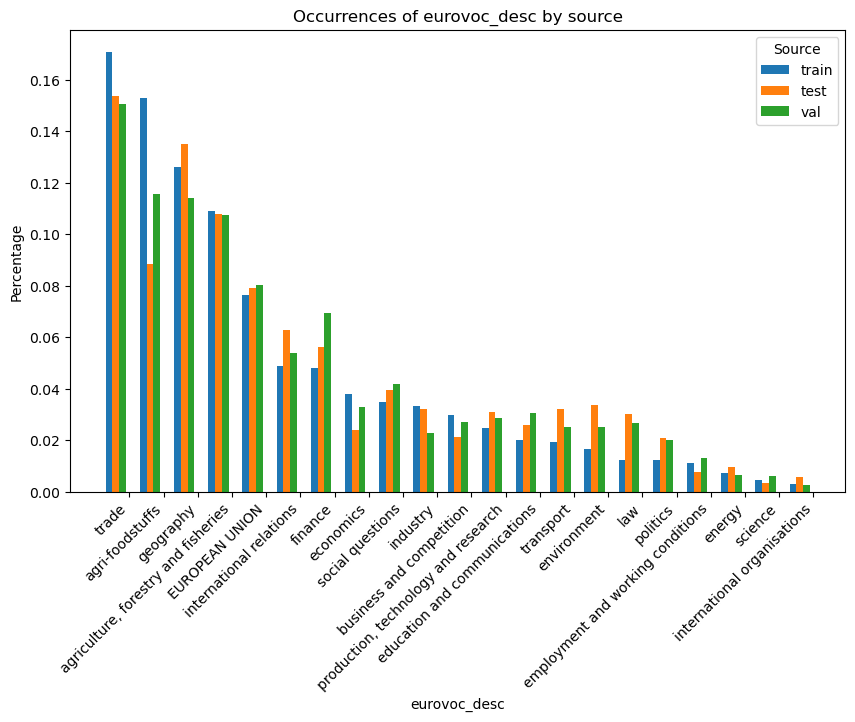

In [79]:
# Get feature map info
train_classlabel = en_train.features["labels"].feature
test_classlabel = en_test.features["labels"].feature
val_classlabel = en_val.features["labels"].feature
def process_sample(sample, classlabel):
    labels = [int(label) for label in sample['labels'].replace('[', '').replace(']', '').split()]
    
    results = [
        {
            'celex_id': sample['celex_id'],
            'label_id': label_id,
            'eurovoc_id': classlabel.int2str(label_id),
            'eurovoc_desc': eurovoc_descriptors[classlabel.int2str(label_id)]['en'],
            'eurovoc_level': next((level for level, ids in eurovoc_concepts.items() if classlabel.int2str(label_id) in ids), None)
        }
        for label_id in labels
    ]
    return results

def get_agg_df(dataset, classlabel):
    results = dataset.apply(process_sample, axis=1, classlabel=classlabel)
    return pd.concat([pd.DataFrame(r) for r in results], ignore_index=True)

# Read datasets (this only works with read_csv, not with dataset.to_pandas())
train_dataset = pd.read_csv('./data/full_english_dataset/train_en')
test_dataset = pd.read_csv('./data/full_english_dataset/test_en')
val_dataset = pd.read_csv('./data/full_english_dataset/validation')

train_sample = train_dataset.sample(frac=0.1)
test_sample = test_dataset.sample(frac=0.1)
val_sample = val_dataset.sample(frac=0.1)

# Generate aggregated DataFrames
train_agg_df = get_agg_df(train_sample, train_classlabel)
test_agg_df = get_agg_df(test_sample, test_classlabel)
val_agg_df = get_agg_df(val_sample, val_classlabel)

# Concatenate the DataFrames and create a source column
df = pd.concat([train_agg_df, test_agg_df, val_agg_df], ignore_index=True)
df['source'] = pd.Series(['train'] * len(train_agg_df) + ['test'] * len(test_agg_df) + ['val'] * len(val_agg_df), dtype='string')

# Group, pivot, and normalize the data
df_grouped = df.groupby(['eurovoc_desc', 'source'])\
    .size()\
    .reset_index(name='count')\
    .pivot_table(index='eurovoc_desc', columns='source', values='count')

df_pivot = df_grouped.divide(df_grouped.sum(axis=0), axis=1)\
    .sort_values(by='train', ascending=False)

# Plot a grouped bar chart
fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(df_pivot))
width = 0.2

ax.bar(x - width, df_pivot['train'], width, label='train')
ax.bar(x, df_pivot['test'], width, label='test')
ax.bar(x + width, df_pivot['val'], width, label='val')

ax.set_title('Occurrences of eurovoc_desc by source')
ax.set_xlabel('eurovoc_desc')
ax.set_ylabel('Percentage')
ax.legend(title='Source', loc='upper right')

xticks = x - width / 2 + 0.5
ax.set_xticks(xticks)
ax.set_xticklabels(df_pivot.index, rotation=45, ha='right')

plt.show()

Note that this graph represents a 10% sample of our datasets, so we may not be able to make inferences about the balance of each label, but overall we can know that our dataset has class imbalance. 

# Model and Pipeline

I haven't made the pipeline for preprocessing, bt here's a pipeline with the Logistic Regression model. But here are all the preprocessing steps in one place. 

For our baseline modeling, we will evaluate the efficiency of three methods:
* Random assignment
* Word frequency
* Logistic regression

## Preprocessing

We performed the following preprocessing. You can see details about how our preprocessing works by looking at the nlp_preproc_functions.py library. Our processing includes the following:

- Cleaning labels (Currently has lots of inconsistent formatting, such as extra spaces and commas)
- Creating a feature "pub_date" by extracting the first mentioned date in the document, and saving it as a `pd.datetime` object
    - Some of these dates are inaccurate or incomplete. If so, we're imputing them as the median date for the whole data set
- Preprocessing the documents by:
    - Making all words lower case
    - Removing punctuation
    - Tokenizing
    - Removing stopwords
        - We're also adding words that are in >=50% of documents at least once to the set of stop words
    - Stemming
    - Lemmatizing
- Binarizing the labels
- Getting the type of EU document. The raw text has titles of documents like:
    - Directive of the European Parliament and of the Council
    - Decision of the European Council
    - Regulation of the Council
- We broke this into two categories, WHO and WHAT, and saved them as binary variables:
    - Who:
        - Parliament
        - Council
        - Commission
    - What:
        - Directive
        - Regulation
        - Decision
    - Note: 
        - Each language was assigned the WHO and WHAT variable based on their own language.

In [188]:
def process_all_en(df):
    # fix labels
    df['labels'] = df['labels'].apply(preproc.clean_label)
    #get publishing date feature
    df['pub_date'] = df['text'].apply(preproc.extract_date)
    df = preproc.impute_timestamps(df, 'pub_date')
    #apply standard preprocessing
    df['pp_text'] = df['text'].apply(preproc.preprocess_text_en)
    #add stopwords that occur once in in >=50% of documents
    df = preproc.remove_common_words(df, 'pp_text', 'celex_id', threshold=0.5)
    #Get labels as dummies
    all_labels = set([label for labels in df['labels'] for label in labels])
    mlb = MultiLabelBinarizer()
    labels_df = pd.DataFrame(mlb.fit_transform(df['labels']), columns=mlb.classes_)
    labels_df = labels_df.add_prefix('label_')
    df = pd.concat([df, labels_df], axis=1)
    df = df.drop('labels', axis=1)
    #get document type feature
    df = preproc.get_eu_legal_type_en(df, 'text')
    return df

def process_all_fr(df):
    # fix labels
    df['labels'] = df['labels'].apply(preproc.clean_label)
    print(df.head())
    #Get labels as dummies
    all_labels = set([label for labels in df['labels'] for label in labels])
    mlb = MultiLabelBinarizer()
    labels_df = pd.DataFrame(mlb.fit_transform(df['labels']), columns=mlb.classes_)
    labels_df = labels_df.add_prefix('label_')
    df = pd.concat([df, labels_df], axis=1)
    df = df.drop('labels', axis=1)
    print(df.columns)
    #get document type feature
    df = preproc.get_eu_legal_type_fr(df, 'text')
    print(df.columns)
    #get publishing date feature
    df['pub_date'] = df['text'].apply(preproc.extract_date)
    df = preproc.impute_timestamps(df, 'pub_date')
    #apply standard preprocessing
    df['pp_text'] = df['text'].apply(preproc.preprocess_text_fr)
    #add stopwords that occur once in in >=50% of documents
    df = preproc.remove_common_words(df, 'pp_text', 'celex_id', threshold=0.5)
    
    return df


def process_all_es(df):
    # fix labels
    df['labels'] = df['labels'].apply(preproc.clean_label)
    #get publishing date feature
    df['pub_date'] = df['text'].apply(preproc.extract_date)
    df = preproc.impute_timestamps(df, 'pub_date')
    #apply standard preprocessing
    df['pp_text'] = df['text'].apply(preproc.preprocess_text_es)
    #add stopwords that occur once in in >=50% of documents
    df = preproc.remove_common_words(df, 'pp_text', 'celex_id', threshold=0.5)
    #Get labels as dummies
    all_labels = set([label for labels in df['labels'] for label in labels])
    mlb = MultiLabelBinarizer()
    labels_df = pd.DataFrame(mlb.fit_transform(df['labels']), columns=mlb.classes_)
    labels_df = labels_df.add_prefix('label_')
    df = pd.concat([df, labels_df], axis=1)
    df = df.drop('labels', axis=1)
    #get document type feature
    df = preproc.get_eu_legal_type_es(df, 'text')
    return df

Now, we'll save all three languages to CSV's, then read them into Pandas objects. This is not clean, but we couldn't get the dataset objects to work directly. 

In [189]:
en_val.to_csv('./data/en/original/en_val.csv', index=False)
en_test.to_csv('./data/en/original/en_test.csv', index=False)
en_train.to_csv('./data/en/original/en_train.csv', index=False)

fr_val.to_csv('./data/fr/original/fr_val.csv', index=False)
fr_test.to_csv('./data/fr/original/fr_test.csv', index=False)
fr_train.to_csv('./data/fr/original/fr_train.csv', index=False)

es_val.to_csv('./data/es/original/es_val.csv', index=False)
es_test.to_csv('./data/es/original/es_test.csv', index=False)
es_train.to_csv('./data/es/original/es_train.csv', index=False)

Creating CSV from Arrow format: 100%|██████████| 53/53 [00:06<00:00,  7.94ba/s]


432863840

In [190]:
# Running to_pandas on the dataset object doesn't allow it to be used as a proper dataframe. It only works if I save it as a csv then read into pandas.
# Reading into DF
en_val = pd.read_csv('./data/en/original/en_val.csv')
en_test= pd.read_csv('./data/en/original/en_test.csv')
en_train= pd.read_csv('./data/en/original/en_train.csv')

fr_val= pd.read_csv('./data/fr/original/fr_val.csv')
fr_test= pd.read_csv('./data/fr/original/fr_test.csv')
fr_train= pd.read_csv('./data/fr/original/fr_train.csv')

es_val= pd.read_csv('./data/es/original/es_val.csv')
es_test= pd.read_csv('./data/es/original/es_test.csv')
es_train= pd.read_csv('./data/es/original/es_train.csv')

Now we will preprocess all languages.

In [192]:
en_val_pp = process_all_en(en_val)
print('en_val columns: ',en_val_pp.columns)
fr_val_pp = process_all_fr(fr_val)
print('fr_val columns: ', fr_val_pp.columns)
es_val_pp = process_all_es(es_val)
print('es_val columns: ', es_val_pp.columns)
print('done with val sets')

en_test_pp = process_all_en(en_test)
fr_test_pp = process_all_fr(fr_test)
es_test_pp = process_all_es(es_test)
print('finished with test')
fr_train_pp = process_all_fr(fr_train)
en_train_pp = process_all_en(en_train)
es_train_pp = process_all_es(es_train)

en_val columns:  Index(['index', 'celex_id', 'text', 'pub_date', 'pp_text', 'label_0',
       'label_1', 'label_10', 'label_11', 'label_12', 'label_13', 'label_14',
       'label_15', 'label_16', 'label_17', 'label_18', 'label_19', 'label_2',
       'label_20', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7',
       'label_8', 'label_9', 'commission', 'regulation', 'decision', 'council',
       'directive', 'parliament', 'committee'],
      dtype='object')
     celex_id                                               text  \
0  32012R0782  RÈGLEMENT D'EXÉCUTION (UE) No 782/2012 DE LA C...   
1  32012R0776  RÈGLEMENT D’EXÉCUTION (UE) No 776/2012 DE LA C...   
2  32012R0778  RÈGLEMENT D'EXÉCUTION (UE) No 778/2012 DE LA C...   
3  32012R0779  RÈGLEMENT (UE) No 779/2012 DE LA COMMISSION\nd...   
4  32012R0773  RÈGLEMENT D'EXÉCUTION (UE) No 773/2012 DE LA C...   

               labels  
0       [3, 2, 17, 6]  
1              [4, 6]  
2       [3, 2, 17, 6]  
3  [11, 20, 8, 6, 18]  
4   

In [193]:
en_val_pp.to_csv('./data/en/preproc/en_val_pp.csv', index=False)
en_test_pp.to_csv('./data/en/preproc/en_test_pp.csv', index=False)
en_train_pp.to_csv('./data/en/preproc/en_train_pp.csv', index=False)

fr_val_pp.to_csv('./data/fr/preproc/fr_val_pp.csv', index=False)
fr_test_pp.to_csv('./data/fr/preproc/fr_test_pp.csv', index=False)
fr_train_pp.to_csv('./data/fr/preproc/fr_train_pp.csv', index=False)

es_val_pp.to_csv('./data/es/preproc/es_val_pp.csv', index=False)
es_test_pp.to_csv('./data/es/preproc/es_test_pp.csv', index=False)
es_train_pp.to_csv('./data/es/preproc/es_train_pp.csv', index=False)

## Logistic Regression Model

In [197]:
with open('./log_reg_model.pkl', 'rb') as file:
    en_model = pickle.load(file)

Below is the code I ran the first time I ran the regression. It takes an hour to run so I kept it here and copied the original output. 

In [123]:
# Define the preprocessing steps for the textual data
text_preprocessor = Pipeline(steps=[
    ('count_vect', CountVectorizer(ngram_range=(1,2))), 
    ('scale', StandardScaler(with_mean=False))
    ])

# Define the preprocessing steps for the categorical data
categorical_preprocessor = Pipeline(steps=[('scaler', StandardScaler())])

# Define the column transformer to apply the different preprocessing steps to the different columns
preprocessor = ColumnTransformer(transformers=[
    ('text', text_preprocessor, 'pp_text'),
    ('date', StandardScaler(), ['pub_date']),
    ('categorical', categorical_preprocessor, ['commission', 'regulation', 
                                                'decision', 'council', 'directive', 
                                                'parliament', 'committee'])
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_train_pp[['pp_text', 'pub_date', 
                                                         'commission', 'regulation', 'decision', 
                                                         'council', 'directive', 'parliament', 
                                                         'committee']], 
                                                    df_train_pp[['label_0', 'label_1', 'label_2', 'label_3', 
                                                        'label_4', 'label_5', 'label_6', 'label_7', 
                                                        'label_8', 'label_9', 'label_10', 'label_11', 
                                                        'label_12', 'label_13', 'label_14', 'label_15', 
                                                        'label_16', 'label_17', 'label_18', 'label_19', 
                                                        'label_20']], test_size=0.2, random_state=42)

# Create a pipeline with a placeholder for the classifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', None)])

# Set up the grid search
param_grid = [
    {
        'classifier': [MultiOutputClassifier(LogisticRegression(max_iter=500))],
    },
    {
        'classifier': [LogisticRegression(multi_class='multinomial', max_iter=500)],
    }
]

grid_search = RandomizedSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model and its score
best_model = grid_search.best_estimator_
best_score = best_model.best_score_
print('Best model:', best_model)
print('Best cross-validation accuracy: {:.2f}%'.format(best_score*100))

# Evaluate the performance of the best model on the testing data
score = best_model.score(X_test, y_test)
print('Test accuracy: {:.2f}%'.format(score*100))


Saved output from the above model:
```python
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('count_vect',
                                                                   CountVectorizer(ngram_range=(1,
                                                                                                2))),
                                                                  ('scale',
                                                                   StandardScaler(with_mean=False))]),
                                                  'pp_text'),
                                                 ('date', StandardScaler(),
                                                  ['pub_date']),
                                                 ('categorical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['commission', 'regulation',
                                                   'decision', 'council',
                                                   'directive', 'parliament',
                                                   'committee'])])),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=500)))])
Best cross-validation accuracy: 32.24%
Test accuracy: 32.05%
```

Now let's evaluate this model's performance on three languages

## Logistic regression: English

In [211]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, log_loss, mean_squared_error

# Replace df_train_pp and df_val_pp with the appropriate dataframes for the language you're working on
X_train = en_train_pp[['pp_text', 'pub_date', 'commission', 'regulation', 'decision', 
                       'council', 'directive', 'parliament', 'committee']]
y_train = en_train_pp[['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 
                       'label_8', 'label_9', 'label_10', 'label_11', 'label_12', 'label_13', 'label_14', 'label_15', 
                       'label_16', 'label_17', 'label_18', 'label_19', 'label_20']]

X_val = en_val_pp[['pp_text', 'pub_date', 'commission', 'regulation', 'decision', 
                   'council', 'directive', 'parliament', 'committee']]
y_val = en_val_pp[['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 
                   'label_8', 'label_9', 'label_10', 'label_11', 'label_12', 'label_13', 'label_14', 'label_15', 
                   'label_16', 'label_17', 'label_18', 'label_19', 'label_20']]

# Make predictions using the best_model
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

# Evaluate the predictions (e.g., using accuracy_score, precision_score, recall_score, etc.)
train_f1 = f1_score(y_train, y_train_pred, average='micro')
val_f1 = f1_score(y_val, y_val_pred, average='micro')
train_rocauc = roc_auc_score(y_train, y_train_pred)
val_rocauc = roc_auc_score(y_val, y_val_pred)
train_log_loss = log_loss(y_train, y_train_pred)
val_log_loss = log_loss(y_val, y_val_pred)
train_recall = recall_score(y_train, y_train_pred, average="micro")
val_recall = recall_score(y_val, y_val_pred, average='micro')
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)

print(f"English Train f1: {train_f1:.4f}")
print(f"Validation f1: {val_f1:.4f}")
print(f'Train ROC_AUC: {train_rocauc}')
print(f'Val ROC_AUC: {train_rocauc}')
print(f'Train log_loss: {train_log_loss}')
print(f'Val log_loss: {val_log_loss}')
print(f'Train Recall: {train_recall}')
print(f'Val Recall: {val_recall}')
print(f'Train MSE: {train_mse}')
print(f'Val MSE: {val_mse}')

English Train f1: 0.7956
Validation f1: 0.6857
Train ROC_AUC: 0.7523794304267641
Val ROC_AUC: 0.7523794304267641
Train log_loss: 31.731818866182216
Val log_loss: 50.72586836422719
Train Recall: 0.7268860520200969
Val Recall: 0.5647900398623928
Train MSE: 0.05746147186147188
Val MSE: 0.0903047619047619


Validation F1 is at 68.57%. Let's check other languages

## French Logistic Regression

In [212]:
from sklearn.model_selection import RandomizedSearchCV

# Define the preprocessing steps for the textual data
text_preprocessor = Pipeline(steps=[
    ('count_vect', CountVectorizer(ngram_range=(1,2))), 
    ('scale', StandardScaler(with_mean=False))
    ])

# Define the preprocessing steps for the categorical data
categorical_preprocessor = Pipeline(steps=[('scaler', StandardScaler())])

# Define the column transformer to apply the different preprocessing steps to the different columns
preprocessor = ColumnTransformer(transformers=[
    ('text', text_preprocessor, 'pp_text'),
    ('date', StandardScaler(), ['pub_date']),
    ('categorical', categorical_preprocessor, ['commission', 'regulation', 
                                                'decision', 'council', 'directive', 
                                                'parliament', 'committee'])
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(fr_train_pp[['pp_text', 'pub_date', 
                                                         'commission', 'regulation', 'decision', 
                                                         'council', 'directive', 'parliament', 
                                                         'committee']], 
                                                    fr_train_pp[['label_0', 'label_1', 'label_2', 'label_3', 
                                                        'label_4', 'label_5', 'label_6', 'label_7', 
                                                        'label_8', 'label_9', 'label_10', 'label_11', 
                                                        'label_12', 'label_13', 'label_14', 'label_15', 
                                                        'label_16', 'label_17', 'label_18', 'label_19', 
                                                        'label_20']], test_size=0.2, random_state=42)

# Create a pipeline with a placeholder for the classifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', None)])

# Set up the grid search
param_grid = [
    {
        'classifier': [MultiOutputClassifier(LogisticRegression(max_iter=500))],
    },
    {
        'classifier': [LogisticRegression(multi_class='multinomial', max_iter=500)],
    }
]

grid_search = RandomizedSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='f1')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model and its score
best_model = grid_search.best_estimator_
best_score = best_model.best_score_
print('Best model:', best_model)
print('Best cross-validation accuracy: {:.2f}%'.format(best_score*100))

# Evaluate the performance of the best model on the testing data
score = best_model.score(X_test, y_test)
print('Test accuracy: {:.2f}%'.format(score*100))

from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, log_loss

# Replace df_train_pp and df_val_pp with the appropriate dataframes for the language you're working on
X_train = fr_train_pp[['pp_text', 'pub_date', 'commission', 'regulation', 'decision', 
                       'council', 'directive', 'parliament', 'committee']]
y_train = fr_train_pp[['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 
                       'label_8', 'label_9', 'label_10', 'label_11', 'label_12', 'label_13', 'label_14', 'label_15', 
                       'label_16', 'label_17', 'label_18', 'label_19', 'label_20']]

X_val = fr_val_pp[['pp_text', 'pub_date', 'commission', 'regulation', 'decision', 
                   'council', 'directive', 'parliament', 'committee']]
y_val = fr_val_pp[['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 
                   'label_8', 'label_9', 'label_10', 'label_11', 'label_12', 'label_13', 'label_14', 'label_15', 
                   'label_16', 'label_17', 'label_18', 'label_19', 'label_20']]

# Make predictions using the best_model
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

# Evaluate the predictions (e.g., using accuracy_score, precision_score, recall_score, etc.)
train_f1 = f1_score(y_train, y_train_pred, average='micro')
val_f1 = f1_score(y_val, y_val_pred, average='micro')
train_rocauc = roc_auc_score(y_train, y_train_pred)
val_rocauc = roc_auc_score(y_val, y_val_pred)
train_log_loss = log_loss(y_train, y_train_pred)
val_log_loss = log_loss(y_val, y_val_pred)

print(f"French Train f1: {train_f1:.4f}")
print(f"Validation f1: {val_f1:.4f}")
print(f'Train ROC_AUC: {train_rocauc}')
print(f'Val ROC_AUC: {train_rocauc}')
print(f'Train log_loss: {train_log_loss}')
print(f'Val log_loss: {val_log_loss}')

/Users/jon/miniconda3/envs/nlp-final/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [51]:
df_y_pred = pd.DataFrame(y_pred, columns=['pred_label_{}'.format(i) for i in range(y_pred.shape[1])])

# Reset the indices of X_val, y_val, and df_y_pred
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
df_y_pred = df_y_pred.reset_index(drop=True)

# Concatenate X_val, y_val, and df_y_pred along the columns
df_results = pd.concat([X_val[['pp_text']], y_val, df_y_pred], axis=1)

In [52]:
labels_desc = df.drop_duplicates(subset='label_id')[['label_id', 'eurovoc_desc']]
labels_desc.columns

NameError: name 'df' is not defined

In [ ]:
# Join the two DataFrames on the label_id column
df_merged = df_results.merge(labels_desc, left_on='label_{}'.format(i), right_on='label_id')

# Calculate the F1 score for each label
f1_scores = []
for i in range(21):
    score = f1_score(df_merged['label_{}'.format(i)], df_merged['pred_label_{}'.format(i)], average='micro')
    f1_scores.append(score)

# Get the eurovoc_desc for the x-axis
labels = df_merged['eurovoc_desc'].unique()

# Sort the F1 scores in descending order
sorted_indices = np.argsort(f1_scores)[::-1]
f1_scores_sorted = [f1_scores[i] for i in sorted_indices]
labels_sorted = [labels[i] for i in sorted_indices]

# Create a bar chart of the F1 scores
plt.figure(figsize=(10, 5))
plt.bar(labels_sorted, f1_scores_sorted)
plt.xticks(rotation=90)
plt.xlabel('eurovoc_desc')
plt.ylabel('F1 Score')
plt.title('F1 Scores by eurovoc_desc (Sorted by Score)')
plt.show()


In [ ]:
df_pivot

In [ ]:
..